In [243]:
import os
import glob
import datetime
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [171]:
TRAIN_DIR = '/kaggle/input/covid-19-x-rays-images/train/'
VAL_DIR = '/kaggle/input/covid-19-x-rays-images/val/'
TEST_DIR = '/kaggle/input/covid-19-x-rays-images/test/'

In [260]:
non_covid = glob.glob(f"{os.path.join(TRAIN_DIR, '0')}/*.png")[:4]
covid =  glob.glob(f"{os.path.join(TRAIN_DIR, '1')}/*.png")[:4]

### Non-Covid Images

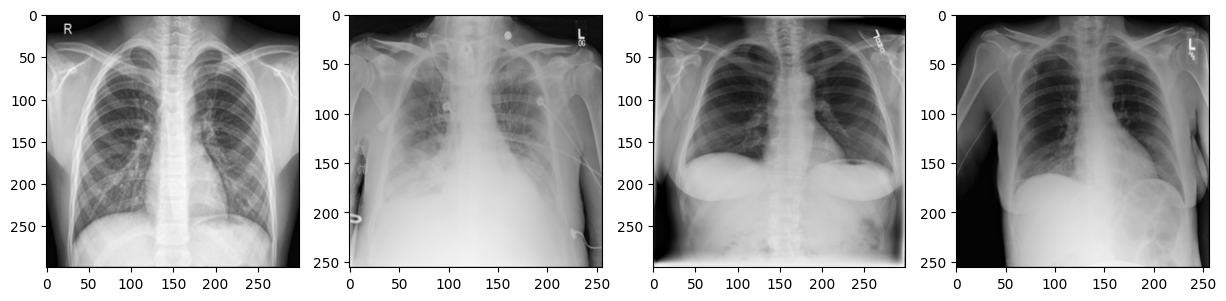

In [262]:
fig, ax = plt.subplots(figsize=(15,4), ncols=4, nrows=1)
ax = ax.flatten()
for i in range(4):
    img = cv2.imread(non_covid[i])
    ax[i].imshow(img)

### Covid Images

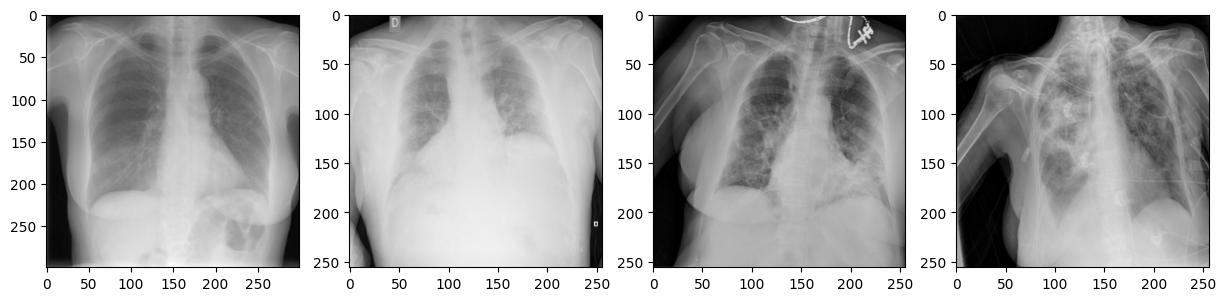

In [263]:
fig, ax = plt.subplots(figsize=(15,4), ncols=4, nrows=1)
ax = ax.flatten()
for i in range(4):
    img = cv2.imread(covid[i])
    ax[i].imshow(img)

### Parameters

In [179]:
# Initialize
LR = 1e-3
EPOCHS = 20
BATCH_SIZE = 64
TARGET_SIZE = (224, 224)

### Data Augmentation

In [183]:
# create data generators with image augmentation for training
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size=TARGET_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    class_mode='binary'
                                                   )

Found 7000 images belonging to 2 classes.


In [184]:
# create data generators with image augmentation for validation
val_datagen = ImageDataGenerator(rescale=1./255.0)

val_generator = val_datagen.flow_from_directory(VAL_DIR,
                                                target_size=TARGET_SIZE,
                                                batch_size=BATCH_SIZE,
                                                class_mode='binary'
                                               )

Found 1500 images belonging to 2 classes.


## Build the model

In [185]:
def build_model():
    # load Xception model and ensuring the head FC layer sets are left off.
    base_model = tf.keras.applications.Xception(weights="imagenet",
                                          include_top=False,
                                          input_shape=(224,224, 3))
    
    for layer in base_model.layers[:-50]:
        layer.trainable = False
        
    # construct the head of the model that will be placed on top the above of base model
    model = tf.keras.models.Sequential()
    model.add(base_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model

## Train and compile the model 

In [196]:
def compile_model(model):
    model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR), 
      loss='binary_crossentropy', 
      metrics=['accuracy'])
    
    # define callbacks
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                             patience=5,
                                             verbose=1,
                                             mode='max',
                                             restore_best_weights=True)

    # Fit the model
    history = model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=30,
                        callbacks=earlystop)
    
    return history

In [197]:
model = build_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 20,863,529
Trainable params: 12,170,353
Non-trainable params: 8,693,176
_________________________________________________________________


In [199]:
model = build_model()
history = compile_model(model)

Epoch 1/30
110/110 [==============================] - 143s 1s/step - loss: 0.3276 - accuracy: 0.8604 - val_loss: 0.2342 - val_accuracy: 0.9087
Epoch 2/30
110/110 [==============================] - 127s 1s/step - loss: 0.2004 - accuracy: 0.9197 - val_loss: 0.1544 - val_accuracy: 0.9413
Epoch 3/30
110/110 [==============================] - 128s 1s/step - loss: 0.1604 - accuracy: 0.9383 - val_loss: 0.1980 - val_accuracy: 0.9253
Epoch 4/30
110/110 [==============================] - 130s 1s/step - loss: 0.1362 - accuracy: 0.9457 - val_loss: 0.1458 - val_accuracy: 0.9473
Epoch 5/30
110/110 [==============================] - 131s 1s/step - loss: 0.1185 - accuracy: 0.9564 - val_loss: 0.2088 - val_accuracy: 0.9207
Epoch 6/30
110/110 [==============================] - 130s 1s/step - loss: 0.1125 - accuracy: 0.9559 - val_loss: 0.2196 - val_accuracy: 0.9200
Epoch 7/30
110/110 [==============================] - 130s 1s/step - loss: 0.0913 - accuracy: 0.9680 - val_loss: 0.1242 - val_accuracy: 0.9587

## Model Evaluation

In [286]:
def plot(history, string, y):
    plt.plot(history.history[string], label='training')
    plt.plot(history.history[f'val_{string}'], label='validation')
    plt.xlabel('Epoch')
    plt.ylabel(string)
    plt.ylim(y)
    plt.title(f'model {string}')
    plt.legend(loc='upper left')
    plt.savefig(f"/kaggle/working/models/model_{string}.png");

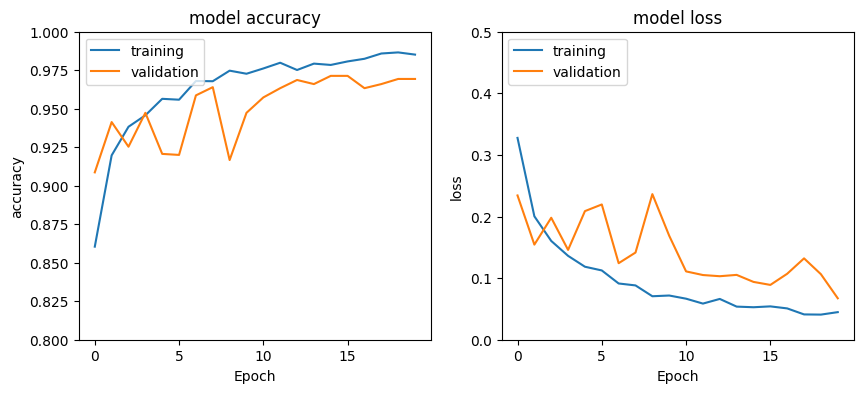

In [287]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plot(history, 'accuracy', y=(0.8, 1.0))
plt.subplot(1,2,2)
plot(history, 'loss', y=(0, 0.5))

## Save Model

In [205]:
timestamp = datetime.date.today()
file_path = os.path.join('/kaggle/working/models', f'{str(timestamp)}_xception.h5')
model.save(file_path)

## Inference

In [244]:
model = tf.keras.models.load_model('/kaggle/working/models/2023-09-02_xception.h5')

In [245]:
test_datagen = ImageDataGenerator(rescale=1./255.0)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                target_size=TARGET_SIZE,
                                                batch_size=BATCH_SIZE,
                                                shuffle=False,
                                                class_mode='binary'
                                               )

Found 1500 images belonging to 2 classes.


In [246]:
predicted = model.predict(test_generator, verbose=1)

24/24 [==============================] - 10s 326ms/step


In [247]:
predicted.shape

(1500, 1)

In [248]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"\nTest Loss: {round(test_loss, 4)}")
print(f"Test Accuracy: {round(test_accuracy, 4)}")

24/24 [==============================] - 7s 275ms/step - loss: 0.1014 - accuracy: 0.9660

Test Loss: 0.1014
Test Accuracy: 0.966


In [296]:
true_classes = test_generator.classes
true_classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [295]:
predicted_classes = np.round(predicted)
predicted_classes

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [0.]], dtype=float32)

### Confusion Matrix

In [298]:
cm = confusion_matrix(true_classes, predicted_classes)
cm_normalized = confusion_matrix(true_classes, predicted_classes, normalize='true')
cm

array([[735,  15],
       [ 36, 714]])

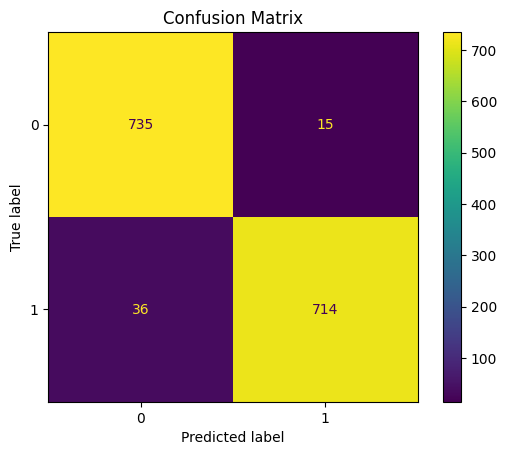

In [299]:
# Create the ConfusionMatrixDisplay object
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

# plot the confusion matrix
cm_display.plot() 
plt.title("Confusion Matrix")
plt.savefig("/kaggle/working/models/confusion_matrix.png");

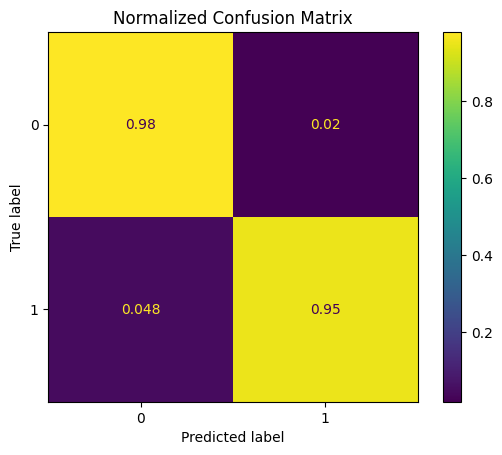

In [300]:
# Create the ConfusionMatrixDisplay object
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)

# plot the normalized confusion matrix
cm_display.plot() 
plt.title("Normalized Confusion Matrix")
plt.savefig("/kaggle/working/models/normalized_confusion_matrix.png");